In [1]:
from utils import harris, dist2, find_sift
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import skimage
from skimage.transform import ProjectiveTransform, warp
import numpy as np
import cv2

## 1. Load images and Convert to grayscale

In [2]:
# Problem 1
img1 = Image.open("uttower_left.jpg").convert('L')
img1 = np.array(img1, dtype = np.float32)

img2 = Image.open("uttower_right.jpg").convert('L')
img2 = np.array(img2, dtype = np.float32)

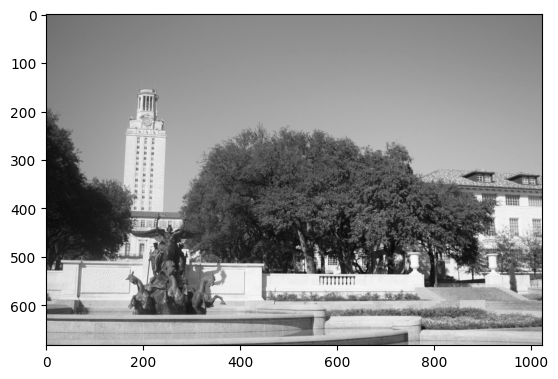

In [3]:
plt.imshow(img1, cmap='gray')

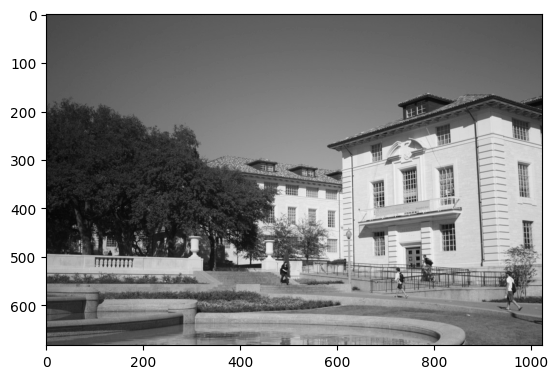

In [4]:
plt.imshow(img2, cmap='gray')

## 2. Detect Feature Points

In [5]:
# Problem 2

cim1, r1, c1 = harris(img1, 3, 100, 3)
cim2, r2, c2 = harris(img2, 3, 100, 3)

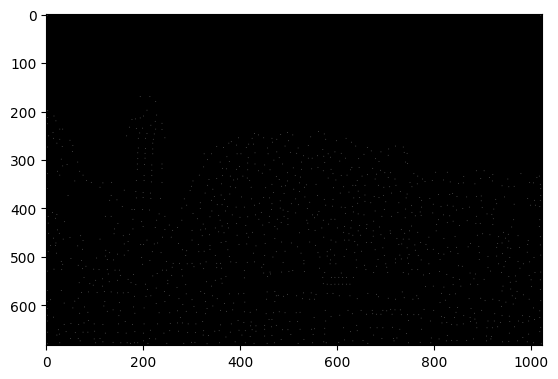

In [6]:
plt.imshow(cim1, cmap='gray')

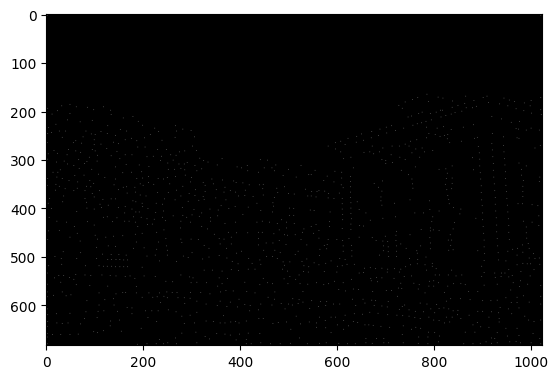

In [7]:
plt.imshow(cim2, cmap='gray')

In [8]:
def draw_corners(img, r, c):
    img_copy = img.copy()
    fig, ax = plt.subplots(figsize = (10, 10))
    for i in range(1, len(r)):
        rect = patches.Rectangle((c[i], r[i]), 10, 10, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img_copy, cmap='gray')

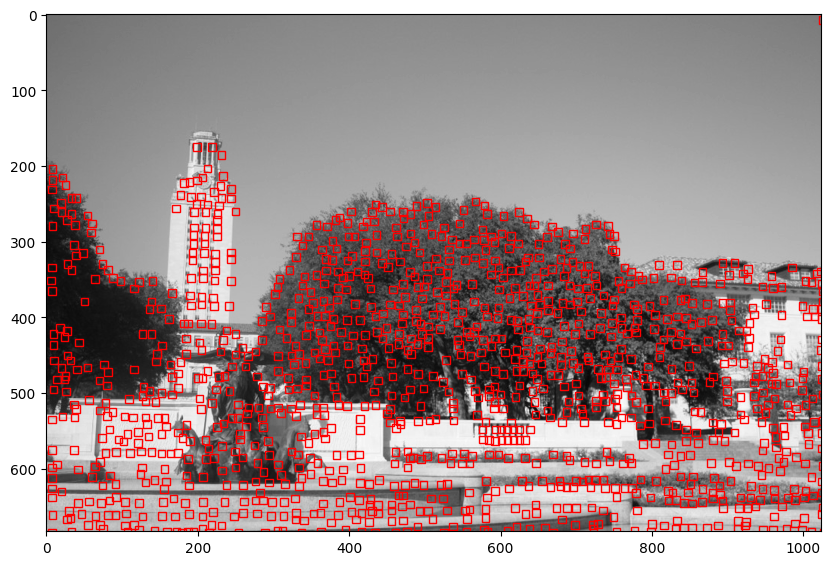

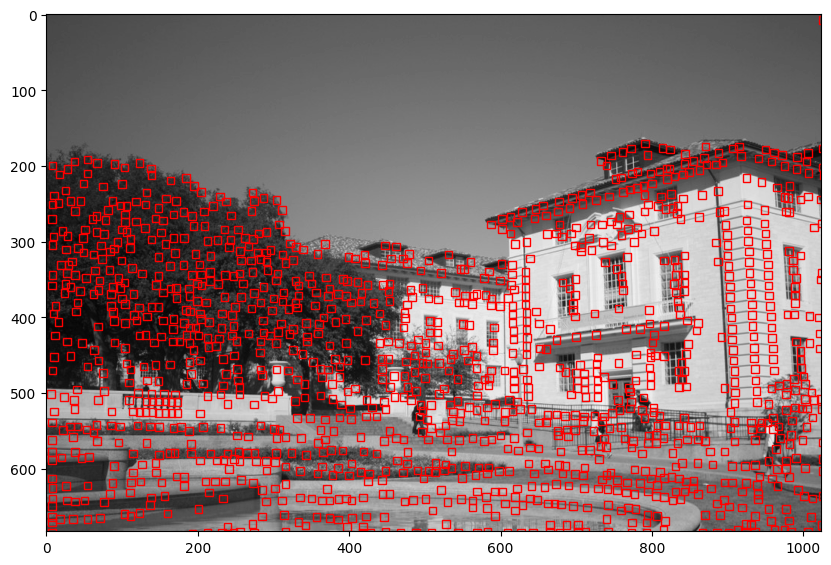

In [9]:
draw_corners(img1, r1, c1)
draw_corners(img2, r2, c2)

## 3. Extract local neighborhoods around every keypoint

In [10]:
def read_and_convert(img_path):
    return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)

def get_sift_data(sift, img):
    k, d = sift.detectAndCompute(img, None)
    return k, d

img1 = read_and_convert('uttower_left.JPG')
img2 = read_and_convert('uttower_right.jpg')

sift = cv2.SIFT_create()

k1, d1 = get_sift_data(sift, img1)
k2, d2 = get_sift_data(sift, img2)

k1, k2 = np.array(k1), np.array(k2)


## 4. Compute distances between descriptors

In [11]:
# Problem 4 (takes 2 mins on my laptop to run)

# Left Image distances
distance = dist2(d1, d2)
distance

array([[300123., 415214., 365821., ..., 373807., 246650., 273810.],
       [383405., 468478., 353665., ..., 369671., 172190., 349110.],
       [339617., 420832., 289819., ..., 374973., 272270., 227330.],
       ...,
       [272945., 417734., 322629., ..., 290039., 259490., 265624.],
       [357722., 349565., 275108., ..., 399784., 377505., 302733.],
       [266878., 285667., 339296., ..., 326504., 362027., 327207.]],
      dtype=float32)

## 5. Select Matches

In [12]:
def get_best_matches(num_matches):
    top_indices = np.argsort(distance, axis=None)[:num_matches]
    match_indices = np.transpose(np.unravel_index(top_indices, distance.shape))

    data = np.hstack((np.array([k1[idx[0]].pt for idx in match_indices]), 
                      np.array([k2[idx[1]].pt for idx in match_indices])))

    return data

## 6. RANSAC

In [13]:
# Problem 6

img1 = cv2.imread("uttower_left.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("uttower_right.jpg", cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
k1, d1 = orb.detectAndCompute(img1, None)
k2, d2 = orb.detectAndCompute(img2, None)

index_params = dict(algorithm = 6, table_number = 6, key_size = 12, multi_probe_level = 2)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(d1, d2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.60 * n.distance:
        good_matches.append([m])

pts1 = np.float32([k1[m[0].queryIdx].pt for m in good_matches])
pts2 = np.float32([k2[m[0].trainIdx].pt for m in good_matches])

# RANSAC parameters
num_iterations = 999
inlier_threshold = 9.0
best_num_inliers = 0
best_model = None

# RANSAC loop
for i in range(num_iterations):
    random_indices = np.random.choice(len(good_matches), 4, replace=False)
    src_points = pts1[random_indices]
    dst_points = pts2[random_indices]

    model, _ = cv2.findHomography(src_points, dst_points)
    transformed_pts = cv2.perspectiveTransform(pts1.reshape(-1, 1, 2), model)
    distances = np.linalg.norm(transformed_pts.squeeze() - pts2, axis=1)
    num_inliers = np.sum(distances < inlier_threshold)

    if num_inliers > best_num_inliers:
        best_num_inliers = num_inliers
        best_model = model

print('Inliners: %d' % best_num_inliers)
residual = np.sum((pts2 - cv2.perspectiveTransform(pts1.reshape(-1, 1, 2), best_model)) ** 2) / best_num_inliers
print('Residual: ', residual)

Inliners: 67
Residual:  1859355.462686567


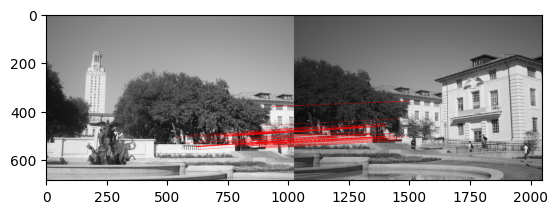

In [14]:
def draw_matches(img1, img2, kp1, kp2, matches, color=None): 
    h1, w1 = img1.shape[:2] 
    h2, w2 = img2.shape[:2]
    vis = np.zeros((max(h1, h2), w1 + w2), np.uint8)
    vis[:h1, :w1] = img1
    vis[:h2, w1:w1 + w2] = img2
    vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)
    
    if color is None:
        color = (255)

    for m in matches:
        end1 = tuple(np.round(kp1[m[0].queryIdx].pt).astype(int))
        end2 = tuple(np.round(kp2[m[0].trainIdx].pt).astype(int) + np.array([w1, 0]))
        cv2.line(vis, end1, end2, color)
        
    return vis

inliner_img = draw_matches(img1, img2, k1, k2, good_matches, color = None)

plt.imshow(inliner_img)
plt.show()

## 7. Warp one image onto the other

In [15]:
from skimage.transform import ProjectiveTransform, warp

def warp_img(image_left, H, img2):
    h_left, w_left = image_left.shape[:2]
    h_right, w_right = img2.shape[:2]

    C_left = np.array([[0, w_left, w_left, 0], [0, 0, h_left, h_left], [1, 1, 1, 1]])

    Cp_left = H @ C_left
    Cp_left /= Cp_left[-1, :]
    
    w_min, h_min = map(int, np.abs(Cp_left[:-1].min(axis=1)))

    warped_size = (h_left + h_min, w_left + w_min)

    Hw_left = np.array([[1, 0, w_min], [0, 1, h_min], [0, 0, 1]]) @ H
    Hw_left /= Hw_left[-1, -1]

    warped_image_left = warp(image_left, ProjectiveTransform(Hw_left).inverse, output_shape=warped_size)

    Ht_right = np.array([[1, 0, warped_size[1] - w_right], [0, 1, warped_size[0] - h_right], [0, 0, 1]])
    warped_image_right = warp(img2, ProjectiveTransform(Ht_right).inverse, output_shape=warped_size)
    
    return warped_image_left, warped_image_right

warped_img1, warped_img2 = warp_img(img1, best_model, img2)


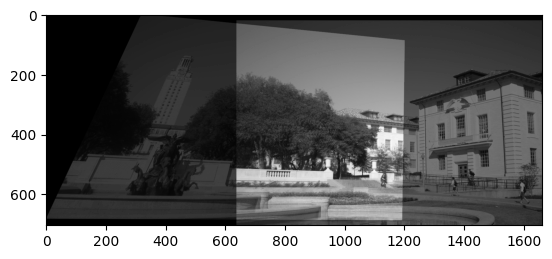

In [16]:
def create_panorama(warped_img1, warped_img2):
    averaged_pixels = np.add(warped_img1, warped_img2)
    averaged_pixels = np.divide(averaged_pixels, 2)

    img1_non_zero = np.where(warped_img1 == 0, 0, 1)
    img2_non_zero = np.where(warped_img2 == 0, 0, 1)

    diff_img1 = np.subtract(averaged_pixels, warped_img1)
    diff_img1 = np.multiply(diff_img1, img1_non_zero)

    masked_img2 = np.multiply(warped_img2, img2_non_zero)

    panorama = np.add(warped_img1, diff_img1)
    panorama = np.add(panorama, masked_img2)

    return panorama

plt.imshow(create_panorama(warped_img1, warped_img2), cmap='gray')
plt.show()


## 8. Create a new image to hold the panorama

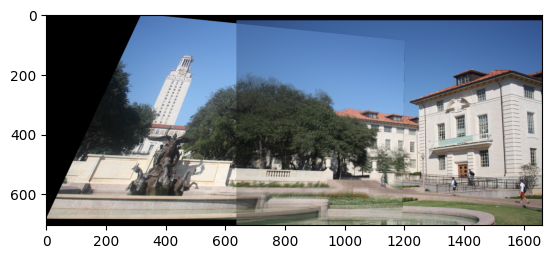

In [17]:
# Problem 8

def create_panorama_rgb(warped_img1, warped_img2):
    averaged_pixels = (warped_img1 + warped_img2) / 2

    warped_img1_zero_mask = (warped_img1 == 0)
    warped_img2_zero_mask = (warped_img2 == 0)

    panorama = np.where(warped_img1_zero_mask, warped_img2, averaged_pixels)
    panorama = np.where(warped_img2_zero_mask, warped_img1, panorama)

    return panorama

img1c = cv2.cvtColor(cv2.imread('uttower_left.JPG'), cv2.COLOR_BGR2RGB)
img2c = cv2.cvtColor(cv2.imread('uttower_right.JPG'), cv2.COLOR_BGR2RGB)

img1cw, img2cw = warp_img(img1c, best_model, img2c)

panorama = create_panorama_rgb(img1cw, img2cw)
plt.imshow(np.clip(panorama, 0, 255).astype(np.uint8))
plt.imshow(panorama)
